# Bayesian Phylogenetics in Linguistics explained

This is a Jupyter notebook that shows you a very simplified example of Bayesian phylogenetics in linguistics, step by step, from the initial data to a resulting summary tree.

## Program libraries
The code here is written in Python. Python comes with a lot of libraries to deal with numerical processes, trees, plotting, and so on; load them here.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy, newick, pandas as pd
DF = pd.DataFrame
from helpers import *

## Language data

Now let us do some Bayesian phylogenetics, starting from a very simple and constructed example. Let us say we have some data like this.

I use lexical data in my example because it is the data type best understood for computational models. The methodology is not specific to it, as I will explain below; Having a different type of data, and corresponding models of language change, will mean that the rest of the methodology can be applied equivalently.


In [2]:
raw_data = DF({
  "Kalang": ['tuˈmun', 'pak', 'ˈrata'],
  "Ta'e": ['ˈana', 'ˈʋula', 'ˈrata'],
  "Sunggama": ['anˈa', 'wuˈla', 'deˈna'],
  "Nda'o": ['ˈana', 'ˈwuɹa', 'ˈn͡dena']},
  index=["child", "moon", "flat"])
raw_data

,Kalang,Nda'o,Sunggama,Ta'e
child,tuˈmun,ˈana,anˈa,ˈana
moon,pak,ˈwuɹa,wuˈla,ˈʋula
flat,ˈrata,ˈn͡dena,deˈna,ˈrata


I will not explain automatic cognate coding in this notebook, so let us for now assume that it can be done and that automatic or manual cognate coding gives us the following cognate table corresponding to the one above.


In [3]:
data = DF({
  "Kl": [1, 1, 1],
  "Ta": [2, 2, 1],
  "Sg": [2, 2, 2],
  "Nd": [2, 2, 2]})
data

,Kl,Nd,Sg,Ta
0,1,2,2,2
1,1,2,2,2
2,1,2,2,1


## Stochastic processes for creating trees

The basic mathematical theorem underlying this kind of inference explains the data as generated by a stochastic process. How might a stochastic process of language change look like? Let us imagine the following process of how languages might split up. This process is a bit bold and simple, but it is the best compromise connecting the mathematical intuition behind the mathematical structure called the “Yule tree prior” and descriptive population dynamics that I could imagine.

Imagine an island region with difficult navigation between the islands, with one island, and later more, supporting an isolated language community with no contact to any other island.

Once in a generation, each inhabited island sends out a boat to try to cross the turbulent seas and settle a new island. Five out of six boats sink in the process, but one in six boats reaches an uninhabited shore and founds a new village there, following the same tradition.

How could we simulate this process?

First, we need a function that describes the turbulences of the seas. Let us use a roll of a six-sided dice, likes this: Press Ctrl-Enter in the following cell to re-roll the die.


In [4]:
big(roll_die())

It is not like we are actually bound to using any realistic random process. We can also just use abstract probabilities for ⛈ and ⛵, like below, but I want to draw on your intuitions of randomness.

In [5]:
if numpy.random.random() < 1/6:
    big("⛵")
else:
    big("⛈")

With our random generator, we can model the crossing of the sea by “Roll a die. Iff you roll a ⚀, the crossing is successful and a new village/speech community is founded.” We can now write a function that takes the language tree at a given point in time and propagates it by one generation by rolling the die for each village. For now, I shall use “a” for the ancestral village, “•” for descendants of a village that stayed and “Δ” (because ⛵) for successful sailors.


In [6]:
def extend_by_one_generation(tree, success="⚀"):
    for village in tree.get_leaves():
        if roll_die() in success:
            village.add_descendant(newick.Node("{:}Δ".format(village.name), "1"))
            village.add_descendant(newick.Node("{:}•".format(village.name), "1"))
        else:
            village.name += "•"
            village.length = village.length + 1
    return tree

def many_generations_later(tree=None, n_generations=7, success="⚀"):
    if tree is None:
        tree = newick.Node("v", "1")
    for i in range(n_generations):
        extend_by_one_generation(tree, success)
    return tree

In [7]:
tree = many_generations_later(newick.Node("a", "1"))
print(tree.newick)

(a••••Δ••:3.0,(a••••••Δ:1,a•••••••:1)a••••••:2.0)a••••:5.0


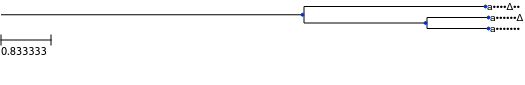

In [8]:
draw(tree)

This now describes a stochastic process of population spread. A different model might be that the sea is much less dangerous and the crossing succeeds in about half the cases, which we model as a dice roll of ⚀⚁⚂.

Obviously, this model is still very similar. This could instead be an entirely different process (maybe there are only so many islands, so the chances of splitting might decrease over time? Maybe sometimes villages die?) but that would only make the explanation more complicated, not actually help us understand the principles of the inference procedure.

We still assume that migration is always to a new, uninhabited place, and with no contact back. Both assumptions make the mathematical calculations sufficiently easy that I can both show them here, and use them in the computer models I run.


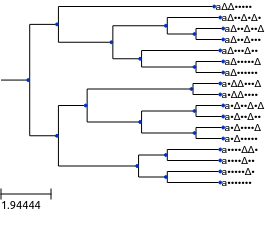

In [9]:
big_tree = many_generations_later(newick.Node("a", "1"), success="⚀⚁⚂")
draw(big_tree)


If you re-run these notebook cells a few times (Ctrl-Enter), or if you have a good mathematical intuition, you will notice that the second tree ends up usually far bigger than the first tree.

## Bayes' Theorem

Now, how does this help us reconstruct language trees? The example lets me show you how to use a mathematical property of probabilities, known as “Bayes' Theorem” after 18th century scholar Thomas Bayes. The theorem relates conditional probabilities.

For our context here, “conditional probability” should be read as “How compatible are two facts”.
For example, a high probability P(A|B) means that the fact A is very compatible with the fact B. A low ‘marginal’ or ‘prior’ probability P(B) can be read as a quantitative way of phrasing ‘I doubt B in general’.

So let us say we are really unsure whether the sea is difficult (⚀⚁⚂) or nigh impossible (⚀) to cross, so we take P(⚀⚁⚂)=P(⚀)=0.5

Now we go to the region, and after some research there, we gather the data given above.

In [10]:
raw_data

,Kalang,Nda'o,Sunggama,Ta'e
child,tuˈmun,ˈana,anˈa,ˈana
moon,pak,ˈwuɹa,wuˈla,ˈʋula
flat,ˈrata,ˈn͡dena,deˈna,ˈrata


Our research might convince us [P(X)=1] of the following two facts.

- There are exactly these four languages spoken in the island region, no more.
- There was a single ancestral village with the tradition described above 7 generations ago.

How compatible is “the sea is difficult to cross” or “the seas is nigh impossible to cross” with this new data?

Bayes' Theorem tells us that

     P(S|D) = P(D|S) * P(S) / P(D)

In this formula, S represents the possible options for the sea, or more generally our model. D is the data, in this case “there are four villages”.
The `P(D|S)` in that formula is the reason we built the computer model above: This conditional probability is not just a measure of compatibility of beliefs, it is also a repeatable experiment like you might think of when you hear the term “probability”: We can run our two models many, many times and count how often we see `D`, that is, how often the tree has exactly 4 leaves.

In [11]:
# P(4 languages | 7 generations, ⚀)
p_one = numpy.mean([len(many_generations_later(n_generations=7, success="⚀").get_leaves())==4 for _ in range(10000)]) * 0.5
p_one


0.0596

In [12]:
# P(4 languages | 7 generations, ⚀⚁⚂)
p_three = numpy.mean([len(many_generations_later(n_generations=7, success="⚀⚁⚂").get_leaves())==4 for _ in range(10000)]) * 0.5
p_three


0.01245

We do not actually have P(D), but we can still calculate the P(S|D) values, the “posterior probabilities”, because we know they are probabilities, so their sum must be one.


In [13]:
p_one, p_three = p_one / (p_one + p_three), p_three / (p_one + p_three)
p_one, p_three

(0.8272033310201249, 0.17279666897987506)


After looking at the data, we see that the ⚀ model is much more convincing than the ⚀⚁⚂ model.
Where we were really unsure before, now we are quite convinced that ⚀ is correct.
We can even put a number on how much better it is: The “Bayes Factor” in favour of ⚀ is


In [14]:
p_one / p_three

4.787148594377511

For the mathematically curious: The data point about the age of the ancestral village – let's call it `A` – is not a random *outcome* of the language split models, but more like an input or a constraint. So in total, the formula would be

    P(⚀  |D, A) = P(D|⚀,   A) * P(S|A) / P(D|A)
    P(⚀⚁⚂|D, A) = P(D|⚀⚁⚂, A) * P(S|A) / P(D|A)

and `P(S|A)` is not a thing we need to derive using another application of Bayes' theorem, but it is exactly what we used above when we wrote `many_generations_later(n_generations=7, success="⚀⚁⚂")`. If this was not the case, it would still not be an insurmountable issue.


## Models of language evolution

Now we have seen the basic principle of Bayes' Theorem in action, we can turn to language data.

Just like for the split of speaker communities, we need an explicit stochastic model that describes how languages change over time. Let us take a stochastic version of the basic assumption of glottochronology and assume that words are replaced by new, unrelated words at random, but averaging out to some fixed underlying speed.

This is an obvious simplification, chosen for the illustration purposes here. The models actually used in phylogenetic inference are also always vast simplifications, but hopefully at least somewhat more robust than the one presented here.

A graphical version of this would be that every generation, let us say just before the boat leaves, the whole speaker community comes together, discusses a set of words – for example, “child”, “moon”, and “flat” from our example data above, and then casts lots. Five out of forty lots mean they invent a new word for this concept, which they use from then on.

We can simulate this decision process by taking a deck of cards

In [15]:
all_cards = """🂱 🂲 🂳 🂴 🂵 🂶 🂷 🂸 🂹 🂺
🂡 🂢 🂣 🂤 🂥 🂦 🂧 🂨 🂩 🂪
🃁 🃂 🃃 🃄 🃅 🃆 🃇 🃈 🃉 🃊
🃑 🃒 🃓 🃔 🃕 🃖 🃗 🃘 🃙 🃚""".split()

def draw_card():
    return all_cards[numpy.random.randint(len(all_cards))]


from which we reveal one, and then put it back and shuffle for the next lottery

In [16]:
big(draw_card())

If the card drawn is one of 🂱, 🂲, 🂳, 🂴, 🂵, the language community invents a new word for that sacred concept, which is not replaced through other means, only possibly affected by sound changes. As a Python function that simulates the evolution of a single concept on a given language tree, this model looks as follows.

In [17]:
def dollo_model_on_tree(tree, new_form="🂱 🂲 🂳 🂴 🂵".split(), existing_forms=None):
    if existing_forms is None:
        existing_forms = set()
    data = {}
    form = invent_random_word()
    existing_forms.add(form)
    for node in tree.walk(mode="preorder"):
        for i in range(int(node.length)):
            if draw_card() in new_form:
                form = invent_random_word()
                existing_forms.add(form)
        data[node.name] = form
    return data



If we run this model on the big tree from above

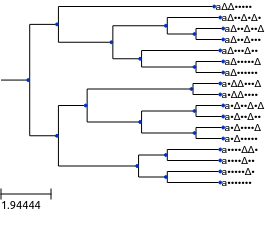

In [18]:
draw(big_tree)

we get the following pattern in all the nodes


In [19]:
dollo_model_on_tree(big_tree)

{'a': 'airnu_waliŋ_wuitoʔ',
 'aΔ': 'airnu_waliŋ_wuitoʔ',
 'aΔΔ•••••': 'uduk',
 'aΔ••': 'uduk',
 'aΔ••Δ•': 'uduk',
 'aΔ••Δ•Δ•': 'ʃukab',
 'aΔ••Δ••': 'ʃukab',
 'aΔ••Δ••Δ': 'ʃukab',
 'aΔ••Δ•••': 'ʃukab',
 'aΔ•••': 'ʃukab',
 'aΔ•••Δ••': 'mançia_sopsobaŋ',
 'aΔ•••••': 'mançia_sopsobaŋ',
 'aΔ•••••Δ': 'mançia_sopsobaŋ',
 'aΔ••••••': 'mançia_sopsobaŋ',
 'a•': 'mançia_sopsobaŋ',
 'a•Δ': 'afa',
 'a•ΔΔ•••': 'loːɣi',
 'a•ΔΔ•••Δ': 'loːɣi',
 'a•ΔΔ••••': 'loːɣi',
 'a•Δ••': 'loːɣi',
 'a•Δ••Δ•': 'loːɣi',
 'a•Δ••Δ•Δ': 'loːɣi',
 'a•Δ••Δ••': 'loːɣi',
 'a•Δ••••': 'suor',
 'a•Δ••••Δ': 'suor',
 'a•Δ•••••': 'suor',
 'a••••': 'suor',
 'a••••Δ': 'suor',
 'a••••ΔΔ•': 'hiʔɔr',
 'a••••Δ••': 'hiʔɔr',
 'a•••••': 'hiʔɔr',
 'a•••••Δ•': 'tiada',
 'a•••••••': 'tiada'}

## Monte Carlo sampling

Now we have a stochastic model for the underlying relationships between the languages, and a model for how that tree influences the evolution of the lexicon of these languages. This means we can randomly generate trees and lexicon data on them. When the lexicon data matches our observed data, we note the tree down in a list. This list will give us an impression of what the actual language history looks like, provided the models are a reasonable approximation of reality.

This strategy of “generate random data and use that in calculations” is called “Monte Carlo sampling”, after the casino in Monaco.

In [20]:
for i, tree in enumerate(naive_monte_carlo(
    tree_generator=many_generations_later,
    models=[dollo_model_on_tree] * 3,
    data=data.to_dict('list'))):
    if tree:
      print(i, tree)
    if i > 50:
        break


Wrong number of leaves: ((v•Δ•••Δ•:2.0,v•Δ•••••:2.0)v•Δ•••:4.0,v•••••••:6.0)v•:2.0
Wrong number of leaves: v•••••••:8.0
Wrong number of leaves: ((v•••Δ•Δ•:2.0,(v•••Δ••Δ:1,v•••Δ•••:1)v•••Δ••:1)v•••Δ•:2.0,(v••••Δ••:3.0,v•••••••:3.0)v••••:1)v•••:4.0
Wrong number of leaves: (v••••Δ••:3.0,(v••••••Δ:1,v•••••••:1)v••••••:2.0)v••••:5.0
Wrong number of leaves: (v•Δ•••••:6.0,v•••••••:6.0)v•:2.0
Not generating the right data: (v••Δ••••:5.0,(v•••Δ•••:4.0,(v•••••Δ•:2.0,v•••••••:2.0)v•••••:2.0)v•••:1)v••:3.0
Not generating the right data: ((v••••ΔΔ•:2.0,v••••Δ••:2.0)v••••Δ:1,(v••••••Δ:1,v•••••••:1)v••••••:2.0)v••••:5.0
Wrong number of leaves: (vΔ••••••:7.0,v•••••••:7.0)v:1
Wrong number of leaves: (((vΔΔ•••Δ•:2.0,vΔΔ•••••:2.0)vΔΔ•••:4.0,vΔ••••••:6.0)vΔ:1,(v•••Δ•••:4.0,(v•••••Δ•:2.0,v•••••••:2.0)v•••••:2.0)v•••:3.0)v:1
Not generating the right data: ((v••Δ•Δ••:3.0,v••Δ••••:3.0)v••Δ•:2.0,(v•••••Δ•:2.0,v•••••••:2.0)v•••••:3.0)v••:3.0
Wrong number of leaves: v•••••••:8.0
Wrong number of leaves: v•••••••:

## Markov chain Monte Carlo

This looks like a very slow process, because most of the trees have the wrong number of leaves.
If we discard the trees that do not have the right number of leaves, and instead remember the last tree that did, we have a much better chance to find matches.

This “remember one previous thing” is a core property of a Markov chain, so this turns our sampler into a Markov chain Monte Carlo sampler. Such an MCMC can employ even more clever shortcuts if more is known analytically about the probabilities of the objects involved. But for the purposes of this illustration, it should be sufficient.


In [21]:
tree_state = None
def random_tree_with_memory(leaves=4):
    global tree_state
    suggestion = many_generations_later()
    if len(suggestion.get_leaves()) == leaves:
        tree_state = suggestion
    return tree_state


In [22]:
log = []
for i, tree in enumerate(naive_monte_carlo(
    tree_generator=random_tree_with_memory,
    models=[dollo_model_on_tree] * 3,
    data=data.to_dict('list'),
    verbose=False)):
    if tree:
        print(i, tree.newick)
        tree.remove_internal_names()
        log.append(tree)
    if i > 10000:
        break


13 ((Kl:5.0,Ta:5.0)v•Δ:1,(Nd:1,Sg:1)v••••••:5.0)v•:2.0
25 ((Nd:3.0,(Sg:2.0,Ta:2.0)v•Δ•••:1)v•Δ••:3.0,Kl:6.0)v•:2.0
421 ((Sg:3.0,Nd:3.0)v•Δ••:3.0,(Ta:3.0,Kl:3.0)v••••:3.0)v•:2.0
638 (Kl:7.0,(Ta:3.0,(Sg:2.0,Nd:2.0)v•••••:1)v••••:4.0)v:1
2381 ((Nd:2.0,Sg:2.0)v••Δ••:3.0,(Ta:2.0,Kl:2.0)v•••••:3.0)v••:3.0
3263 ((Sg:2.0,Nd:2.0)v•Δ•••:4.0,(Ta:5.0,Kl:5.0)v••:1)v•:2.0
3712 (Kl:6.0,((Ta:3.0,Nd:3.0)v••Δ•:2.0,Sg:5.0)v••:1)v•:2.0
4662 (((Nd:1,Sg:1)vΔ••••Δ:1,Ta:2.0)vΔ••••:5.0,Kl:7.0)v:1
5253 ((Kl:2.0,Ta:2.0)vΔ••••:5.0,(Nd:6.0,Sg:6.0)v•:1)v:1
5971 (((Nd:1,Sg:1)v•ΔΔ•••:4.0,Ta:5.0)v•Δ:1,Kl:6.0)v•:2.0
6127 ((Sg:1,Nd:1)v•Δ••••:5.0,(Ta:5.0,Kl:5.0)v••:1)v•:2.0
6785 (((Sg:1,Nd:1)vΔ•Δ•••:4.0,Ta:5.0)vΔ•:2.0,Kl:7.0)v:1
6849 (Kl:6.0,(Ta:3.0,(Sg:1,Nd:1)v••••••:2.0)v••••:3.0)v•:2.0
8398 ((Sg:3.0,(Nd:2.0,Ta:2.0)v•••Δ•:1)v•••Δ:1,Kl:4.0)v•••:4.0
8770 (Kl:7.0,(Ta:5.0,(Nd:1,Sg:1)v••••••:4.0)v••:2.0)v:1
9484 (Kl:5.0,(Ta:4.0,(Sg:1,Nd:1)v••••••:3.0)v•••:1)v••:3.0


In [23]:
for i, tree in enumerate(naive_monte_carlo(
    tree_generator=random_tree_with_memory,
    models=[dollo_model_on_tree] * 3,
    data=data.to_dict('list'),
    verbose=False)):
    if tree:
        tree.remove_internal_names()
        log.append(tree)
    if i > 100000:
        break

with open("fine_trees.nex", "w") as trees:
    newick.dump(log, trees)


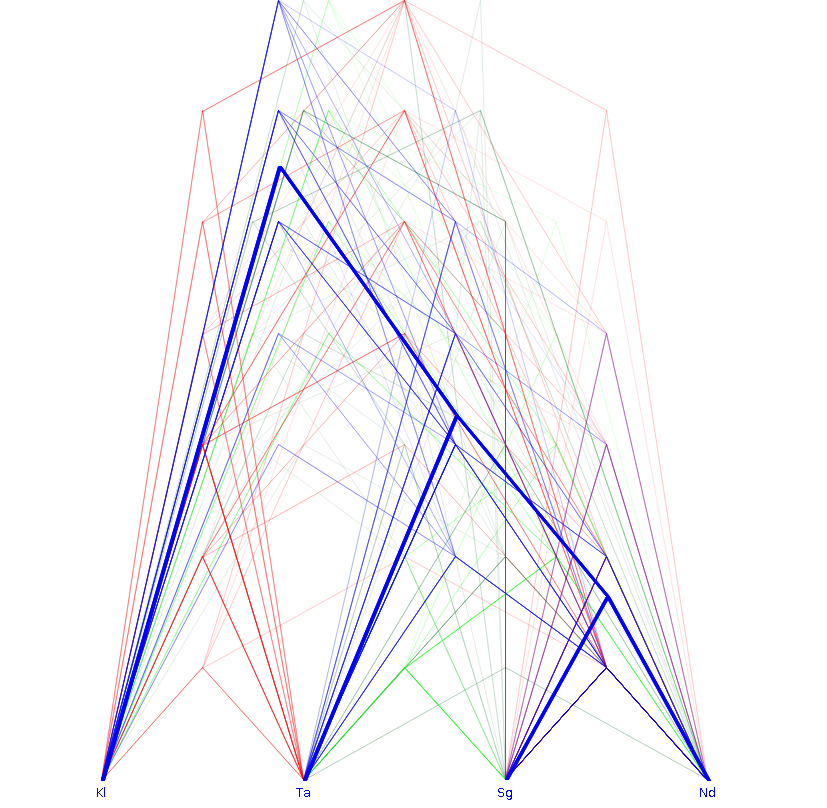

In [24]:
import subprocess
try:
    subprocess.run(["densitree",  "fine_trees.nex"])
except FileNotFoundError:
    pass

Image(filename='densitrees.png')

Now this gives us a lot of trees, but with a clear preference for a tree that groups Nda'o and Sunggama on a low level, and has Kalang splitting off first. This is just based on the lexicon structure (not even the actual phonological forms given here)

In [25]:
raw_data

,Kalang,Nda'o,Sunggama,Ta'e
child,tuˈmun,ˈana,anˈa,ˈana
moon,pak,ˈwuɹa,wuˈla,ˈʋula
flat,ˈrata,ˈn͡dena,deˈna,ˈrata


and while it does not actually recover the dates from the tree below, which is the real tree

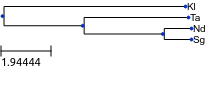

In [26]:
with open("true.tree") as original:
    true = newick.load(original)[0]
draw(true)

it does show the right subgrouping structure at least, just based on this very low number of data points. If you want to see this improve, you can use the function

In [27]:
data = DF(random_observed_data(true, [dollo_model_on_tree] * 10))
data

,Kl,Nd,Sg,Ta
0,ro,fʊi,fʊi,wari
1,adik,lip,wuːb,lip
2,qaqo,taʔata,taʔata,taʔata
3,atinal,gɑthɑrɑ,gɑthɑrɑ,gɑthɑrɑ
4,axebaːqʔ,nei,nei,nei
5,malu,kabɛʔ,kabɛʔ,malu
6,mɔs,mɑli,mɑli,mɔs
7,dʒifar,nanamasine,nanamasine,dʒifar
8,dahaha,dahaha,dahaha,dahaha
9,hɛrɛ,fuː,fuː,hɛrɛ


to generate a longer (still artificial) word list for those languages and see how that improves the quality of the tree inference. But be warned: Our MCMC is very unsophisticated (real inference models use much better shortcuts, derived from a much better mathematical understanding of the models involved), and every new form will increase the time until a tree generates some data with the same underlying shape by an immense amount.